# Proyecto Programación Segura - Vulnerabilidades Machine Learning
## Adversarial Machine Learning: Perturbation
##### Autor: Jesús Cumplido Almenara

# Índice:
* [1. Introducción](#introduction)
* [2. Estado del Arte](#state-of-art)
* [3. Clasificador Inception-V3](#classificator)
* [4. Ataque: Missclassification](#missclassification)
* [5. Ataque: Missclassification with target](#missclassification-with-target)
* [6. Mitigación](#mitigation)
* [7. Conclusión](#conclusion)

# 1. Introducción <a class="anchor" id="introduction"></a>

En este proyecto, vamos a ver varios ejemplos de ataques para engañar a algoritmos de reconocimiento de imágenes de Machine Learning (ML) ya preentrenados, en concreto, el modelo de clasificación Inception-V3 de Google. Tras cargar este modelo, se muestra un ejemplo sencillo de ataque contra el modelo ML basado en la perturbación e inyección de ruido en las imágenes. Se visualizará la efectividad del ataque a través de diferentes ejemplos con diferentes tipos de imágenes para lograr: (1) que el modelo preentrenado clasifique incorrectamente las imágenes con su correspondiente categoría; y (2) lograr que el modelo preentrenado clasifique cualquier imagen sobre la categoría que queramos. Por último, se propondrá un ejemplo de mitigación basado en un estudio de investigación y, finalmente, unas pequeñas conclusiones sobre el trabajo realizado.

El código y contenido de este proyecto ha sido adaptado a partir del proyecto: https://github.com/majestic/targeted-adversarial-attack-examples [1].

# 2. Estado del Arte <a class="anchor" id="state-of-art"></a>

En la última década, es probable que hayas oído a alguien decir, o hayas visto a alguien escribir algo parecido a "*Los ordenadores son mejores que los humanos para reconocer imágenes*". El siguiente gráfico apoya esta idea, mostrando cómo en 2015 se publicó el primer modelo que pudo derrotar la precisión de la clasificación humana en el Desafío de Clasificación de Imágenes de ImageNet.

![image.png](imagenet-progress.png)
(Nota: El error Top-5 se refiere a la frecuencia con la que la respuesta correcta no estaba entre los 5 primeros aciertos de cada clasificador de imágenes)

Impresionante. Te perdonaría que al ver este gráfico pensaras que 2015 fue el año que lo marcó todo, que la humanidad debería resignarse a su futuro estatus de segundona de los ordenadores (al menos en su capacidad de identificar al sujeto de cada foto arbitraria que se les presente). En 2015, un modelo impresionante que surgió y rompió el hito de la "clasificación a nivel humano", fue el propio clasificador Inception-V3 de Google, con un impresionante Error Top-5 de 3,7.

Sin embargo, si el clasificador Inception-V3 es tan imrpesivo, ¿por qué ocurre esto?

![image.png](adversarial-pertubation-cat-guac.png)

Este es un resultado bastante incorrecto. Cuando se le presenta lo que es, obviamente una imagen de un gato, el clasificador de Inception está convencido de que esta imagen es en realidad un guacamole. Al final de este proyecto, se analizará el origen de este resultado, pero mientras tanto volvamos a lo básico y hablemos de cómo se entrenan las redes neuronales.

Los modelos de clasificación de Machine Learning tienen como objetivo: reducir el error del modelo contra el dataset de entrenamiento. En redes neuronales, esto se logra gracias a la técnica de backpropagation y usando el descenso de gradiente para <b>minimizar</b> el error del modelo. Pero, ¿podemos adaptar este concepto para crear una red que, en lugar de intentar crear un modelo que sea bueno en la clasificación, intente crear una imagen que sea muy difícil de clasificar?

# 3. Clasificador Inception-V3  <a class="anchor" id="classificator"></a>

El clasificador Inception-V3 corresponde a una red neuronal convolucional capaz de reconocer multitud de imágenes entre 1000 categorías [2]. Inception-v3 es una red neuronal convolucional preentrenada de 48 capas de profundidad, que es una versión de la red ya entrenada en más de un millón de imágenes de la base de datos ImageNet. Esta red preentrenada puede clasificar las imágenes en 1000 categorías de objetos, como teclado, ratón, lápiz y muchos animales. Como resultado, la red ha aprendido representaciones ricas en características para una amplia gama de imágenes. La red tiene un tamaño de entrada de imágenes de 299 por 299. El modelo extrae características generales de las imágenes de entrada en la primera parte y las clasifica en función de esas características en la segunda.

Inception v3 es un modelo de reconocimiento de imágenes ampliamente utilizado que ha demostrado alcanzar una precisión superior al 78,1% en el conjunto de datos ImageNet y alrededor del 93,9% de precisión en los 5 primeros resultados. El modelo es la culminación de muchas ideas desarrolladas por múltiples investigadores a lo largo de los años. Se basa en el documento original [3].

En primer lugar, cargamos todas las librerías requeridas como son:
- torch
- matplotlib
- numpy
- json

In [188]:
# Import libraries: torch, matplotlib, numpy, json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

import numpy as np
import json

Cargamos el modelo preentrenado: Inception-V3

In [189]:
# Load Inception-v3
model = models.inception_v3(pretrained=True)
model.eval()
print("Loaded inception model")

Loaded inception model


A continuación se muestra las funciones auxiliares usadas para cargar las imágenes de ejemplo y mostrarla junto con su correspondiente predicción.

In [190]:
def load_dataset(data_path, all_classes_inception_path):
    loader = transforms.Compose([transforms.Resize([299, 299]), transforms.ToTensor()])
    data_path = data_path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=loader
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=7,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [192]:
def show_image_and_prediction(i):
    image = data[i]
    prediction = predictions[i]

    with open(all_classes_inception_path, "r") as classes:
        class_idx = json.load(classes)
        plt.imshow(image.cpu().detach().permute(1, 2, 0))
        plt.title("Prediction: " + class_idx[str(prediction)][1])
        plt.axis('off')

Por ejemplo, a continuación se muestran las imágenes y predicciones correctamente de varias fotografías de semáforos (traffic_light) de Málaga, obtenidas de internet.

In [247]:
data_path = "traffic_light_data" # Path where is images of Traffic Light of Malaga
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

for data, target in load_dataset(data_path, all_classes_inception_path):
    output = model(data)

predictions = torch.max(output.data, 1)[1].cpu().numpy()

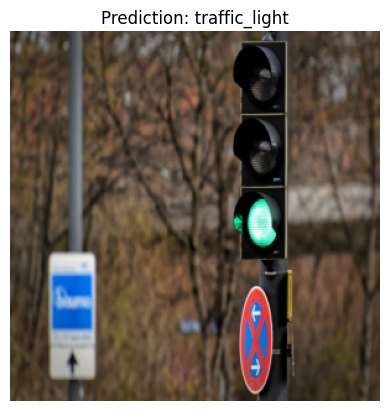

In [195]:
show_image_and_prediction(0)

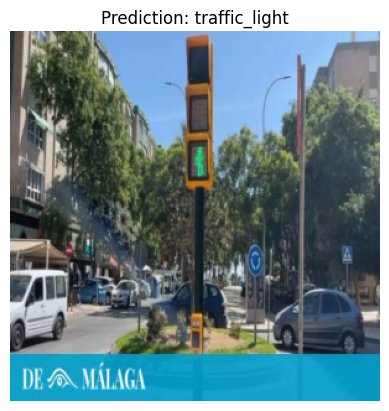

In [196]:
show_image_and_prediction(1)

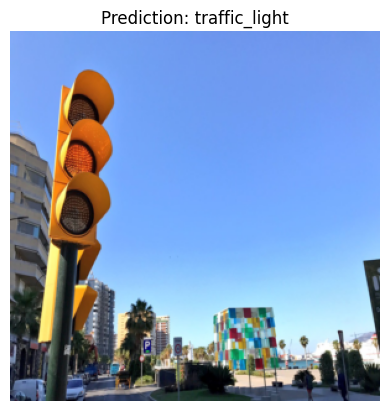

In [197]:
show_image_and_prediction(2)

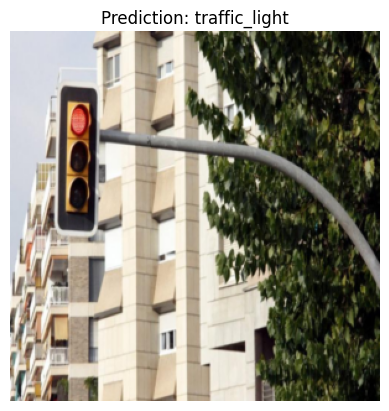

In [198]:
show_image_and_prediction(3)

# 4. Missclassification Attack  <a class="anchor" id="missclassification"></a>

En esta sección, se muestra cómo realizar un ataque de perturbación de imágenes con el objetivo de maximizar el error sobre su target correspondiente, logrando así que el modelo clasificador Inception-V3 clasifique incorrectamente dichas imágenes.

El ataque consiste en la siguiente función que toma una imagen, un épsilon (valor pequeño) y un gradiente. Podemos hacer que la imagen sea más errónea moviendo sus valores (píxeles) en la dirección de su gradiente. 

In [248]:
def create_adversary(image, epsilon, gradient):
    
    # This is the important line, rather than performing a "gradient descent", minimising error
    # I am performing a gradient ascent, altering the image a little, and making it "climb"
    # That gradient as best it can, maximising the error!
    perturbed_image = image + epsilon * gradient
    
    # this just makes sure that the image values are still within its boundaries
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
    return perturbed_image

La siguiente función auxiliar consiste la cual consiste en lo siguiente:
1. Itera sobre cada una de las imágenes obtenidas de un directorio
2. Por cada imagen, comienza un proceso de iteración donde en cada iteración se perturba hasta encontrar una imagen lo suficientemente perturbada que cumple que la predicción del modelo Inception-V3 clasifique erroneamente dicha imagen con respecto el target_class.
3. Finalmente devuelve las imagenes perturbadas y las correspondientes predicciones erróneas.

En resumen, podemos aplicar esta función para "empujar" las imágenes de los semáforos (u otras imágenes) hacia ser más erróneas... El código siguiente cargará las imágenes, las alterará con un pequeño valor en la dirección de su gradiente hasta que haya generado un ejemplo que esté mal clasificado.

In [199]:
def generate_perturbated_images(data_path, all_classes_inception_path, number_images, epsilon, target_class):
    batch_size = number_images
    t = [target_class] * batch_size

    output = None

    example_found = [False] * batch_size
    adversarial_examples = [None] * batch_size
    prediction_names = [None] * batch_size

    num_found = 0


    with open(all_classes_inception_path, "r") as classes:
        class_indexes = json.load(classes)

    # Loop over all examples in test set
    count = 0
    for data, target in load_dataset(data_path, all_classes_inception_path):

        target = torch.LongTensor(t)

        while num_found < number_images:
            count += 1

            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True

            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero  gradients
            model.zero_grad()

            # Calculate gradient
            loss.backward()

            data_grad = data.grad.data

            # Attempt to create an adversary
            perturbed_data = create_adversary(data, epsilon, data.grad)

            if not output is None:
                predictions = torch.max(output.data, 1)[1].cpu().numpy()
                for ii in range(len(predictions)):
                    if example_found[ii] != True and predictions[ii] != target_class:
                        adversarial_examples[ii] = data[ii].cpu().detach().permute(1, 2, 0)
                        example_found[ii] = True
                        prediction_names[ii] = class_indexes[str(predictions[ii])][1]

                        num_found = 0
                        for found in example_found:
                            if found:
                                num_found += 1

                        print(num_found, "adversarial examples have been found after", count, "iterations")

            data = perturbed_data.clone().detach()

            # Re-classify the perturbed image
            output = model(perturbed_data)
    return adversarial_examples, prediction_names

Por otro lado, la siguiente función auxiliar permite dibujar la figura de la imagen perturbada junto con la predicción errónea

In [257]:
def inception_thinks(idx):
    plt.imshow(adversarial_examples[idx])
    plt.title("Inception-V3 Prediction: " + prediction_names[idx].upper())
    plt.axis('off')

## 4.1. Ejemplo 1: Semáforos

In [250]:
data_path = "traffic_light_data" # Path where is images of Traffic Light of Malaga
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

epsilon = 0.1
target_class = 920 # Traffic Light

adversarial_examples, prediction_names = generate_perturbated_images(data_path, all_classes_inception_path, number_images, epsilon, target_class)

1 adversarial examples have been found after 3 iterations
2 adversarial examples have been found after 4 iterations
3 adversarial examples have been found after 5 iterations
4 adversarial examples have been found after 7 iterations


Hemos encontrado algunos ejemplos adversos basados en cada una de las imágenes de semáforos. La función "inception_thinks" nos mostrará la imagen adversa, y lo que el clasificador Inception piensa que es la imagen.

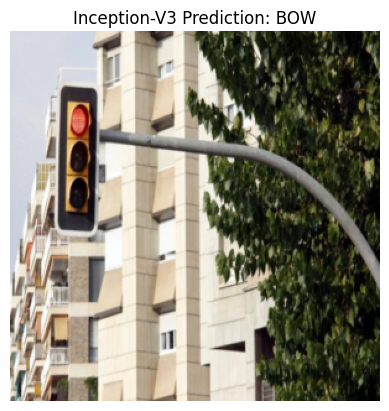

In [258]:
inception_thinks(0)

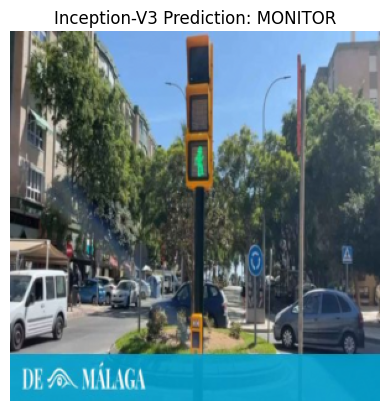

In [259]:
inception_thinks(1)

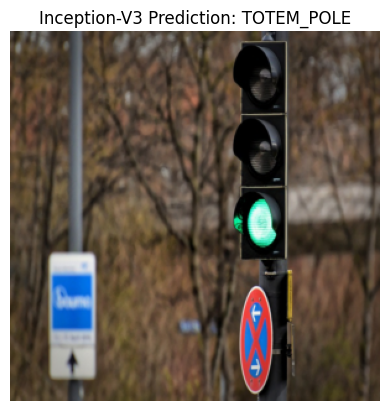

In [260]:
inception_thinks(2)

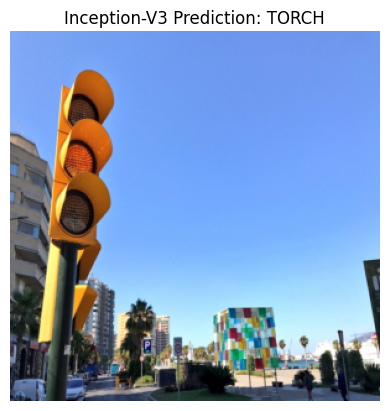

In [261]:
inception_thinks(3)

Espero que sea evidente que se trata de imágenes de semáforos. Sólo han sido alteradas (muy ligeramente). Si se amplía la imagen, se pueden ver algunos píxeles erróneos, pero es algo muy sutil. Sin duda, si un clasificador de imágenes "entiende" las imágenes, debería ser capaz de decir que una imagen de un semáforo con unos pocos píxeles alterados, sigue siendo una imagen de un semáforo.

## Ejemplo 2: Koalas

In [262]:
data_path = "koala" # Path where is images of Koala
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

for data, target in load_dataset(data_path, all_classes_inception_path):
    output = model(data)

predictions = torch.max(output.data, 1)[1].cpu().numpy()

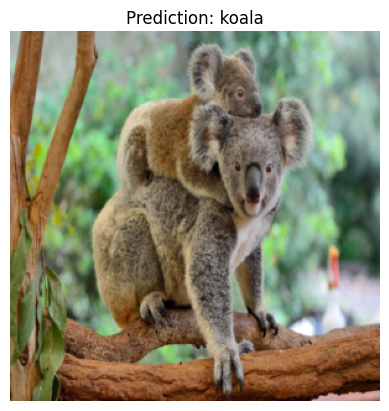

In [263]:
show_image_and_prediction(0)

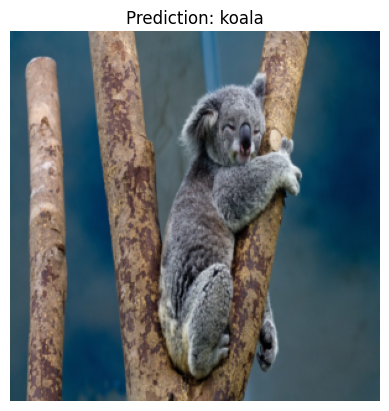

In [266]:
show_image_and_prediction(1)

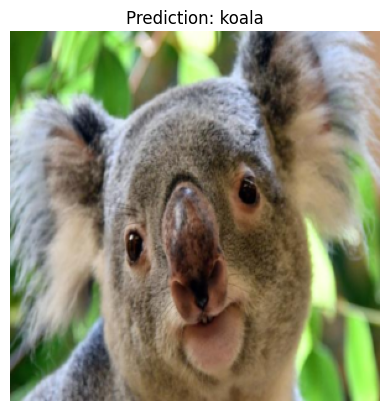

In [267]:
show_image_and_prediction(2)

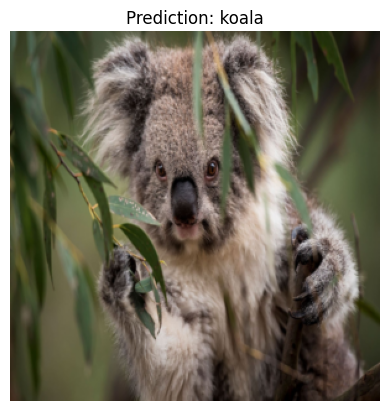

In [268]:
show_image_and_prediction(3)

In [269]:
data_path = "koala" # Path where is images of Koala
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

epsilon = 0.1
target_class = 105 # Koala

adversarial_examples, prediction_names = generate_perturbated_images(data_path, all_classes_inception_path, number_images, epsilon, target_class)

1 adversarial examples have been found after 7 iterations
2 adversarial examples have been found after 14 iterations
3 adversarial examples have been found after 18 iterations
4 adversarial examples have been found after 21 iterations


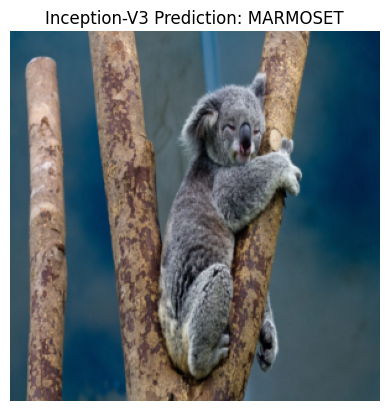

In [270]:
inception_thinks(0)

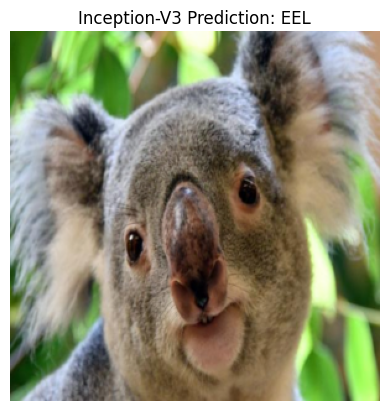

In [271]:
inception_thinks(1)

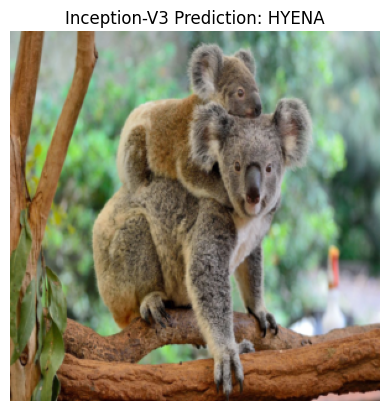

In [272]:
inception_thinks(2)

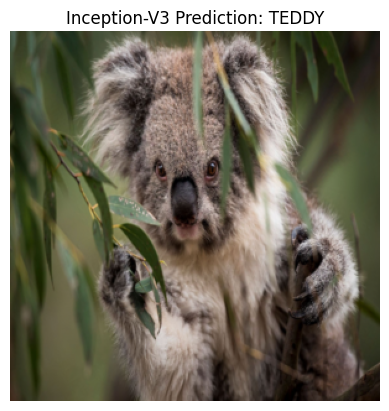

In [273]:
inception_thinks(3)

# 5. Missclassification Attack with a Target <a class="anchor" id="missclassification-with-target"></a>

El siguiente ataque es muy similar al anterior, pero en este caso el objetivo del ataque es lograr que se clasifique cualquier imagen a una categoría al eligir por el atacante que sea. Es decir, alterar y envenenar las imágenes hasta conseguir que el modelo de clasificación clasifique dichas imágenes sobre una categoría objetivo. Podemos lograr esto haciendo algo similar a lo anterior, pero en lugar de maximizar el error, <b>minimizamos el error contra una clase objetivo falsa</b>.

A continuación se muestra la nueva función de perturbación de imágenes la cual tiene la ligera diferencia de minimizar el error (resta, en vez de suma) en vez de maximizarlo. 

In [274]:
def create_targeted_adversary(image, epsilon, gradient):
    
    # Similar to before, but now we are minimizing error!
    perturbed_image = image - epsilon * gradient
    
    # this just makes sure that the image values are still within its boundaries
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
    return perturbed_image

In [275]:
def generate_perturbated_images_with_target(data_path, all_classes_inception_path, number_images, epsilon, target_class):
    batch_size = number_images
    t = [target_class] * batch_size
    output = None
    example_found = [False] * batch_size
    adversarial_examples = [None] * batch_size
    prediction_names = [None] * batch_size

    num_found = 0


    with open(all_classes_inception_path, "r") as classes:
        class_indexes = json.load(classes)

    # Loop over all examples in test set
    count = 0
    for data, target in load_dataset(data_path, all_classes_inception_path):

        target = torch.LongTensor(t)

        while num_found < number_images:
            count += 1

            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True

            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero  gradients
            model.zero_grad()

            # Calculate gradient
            loss.backward()

            data_grad = data.grad.data

            # Attempt to create a targeted adversary
            perturbed_data = create_targeted_adversary(data, epsilon, data.grad)

            if not output is None:
                predictions = torch.max(output.data, 1)[1].cpu().numpy()
                for ii in range(len(predictions)):
                    if example_found[ii] != True and predictions[ii] == target_class:
                        adversarial_examples[ii] = data[ii].cpu().detach().permute(1, 2, 0)
                        example_found[ii] = True
                        prediction_names[ii] = class_indexes[str(predictions[ii])][1]

                        num_found = 0
                        for found in example_found:
                            if found:
                                num_found += 1

                        print(num_found, "adversarial examples have been found after", count, "iterations")

            data = perturbed_data.clone().detach()

            # Re-classify the perturbed image
            output = model(perturbed_data)
            
    return adversarial_examples, prediction_names

## 5.1. Ejemplo 1: Semáforos -> Gafas de sol

In [276]:
data_path = "traffic_light_data" # Path where is images of Traffic Light of Malaga
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

epsilon = 0.1
target_class = 837 # Sunglasses

adversarial_examples, prediction_names = generate_perturbated_images_with_target(data_path, all_classes_inception_path, number_images, epsilon, target_class)

1 adversarial examples have been found after 10 iterations
2 adversarial examples have been found after 12 iterations
3 adversarial examples have been found after 20 iterations
4 adversarial examples have been found after 24 iterations


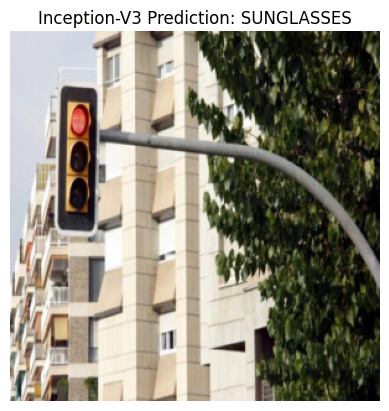

In [277]:
inception_thinks(0)

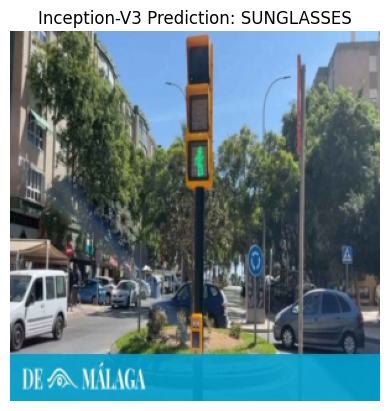

In [278]:
inception_thinks(1)

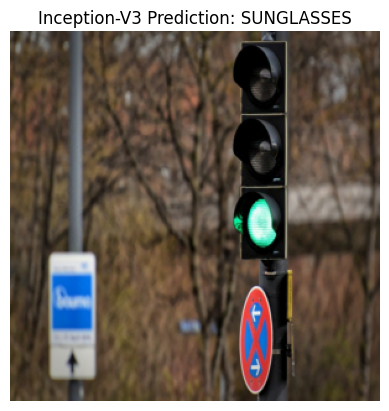

In [279]:
inception_thinks(2)

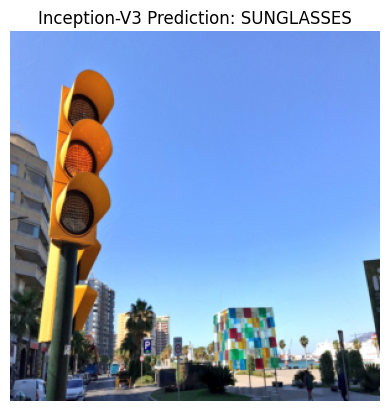

In [280]:
inception_thinks(3)

## 5.2. Ejemplo 2: Koalas ->  Portátiles

In [281]:
data_path = "koala" # Path where is images of Koala
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 4

epsilon = 0.1
target_class = 620 # Laptop

adversarial_examples, prediction_names = generate_perturbated_images_with_target(data_path, all_classes_inception_path, number_images, epsilon, target_class)

1 adversarial examples have been found after 15 iterations
2 adversarial examples have been found after 37 iterations
3 adversarial examples have been found after 49 iterations
4 adversarial examples have been found after 86 iterations


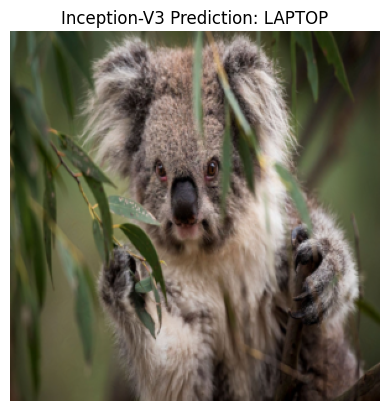

In [282]:
inception_thinks(0)

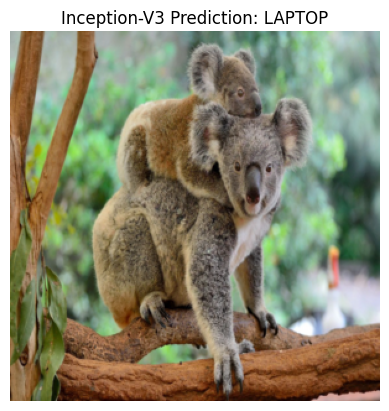

In [283]:
inception_thinks(1)

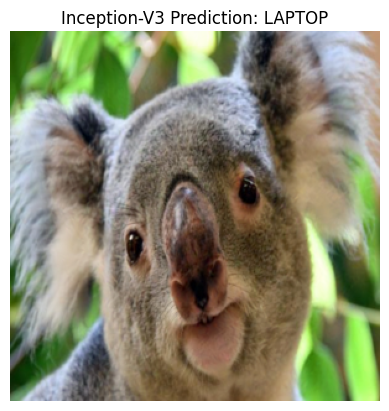

In [284]:
inception_thinks(2)

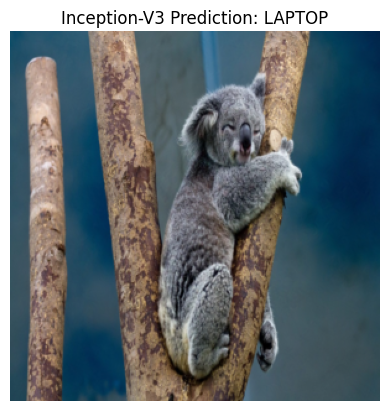

In [285]:
inception_thinks(3)

## 5.3. Ejemplo Final: Gatos -> Guacamole

In [286]:
data_path = "cats" # Path where is images of Koala
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 5

for data, target in load_dataset(data_path, all_classes_inception_path):
    output = model(data)

predictions = torch.max(output.data, 1)[1].cpu().numpy()

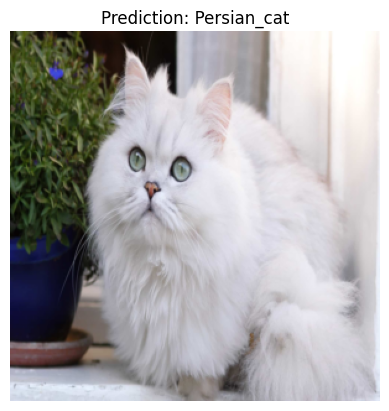

In [287]:
show_image_and_prediction(0)

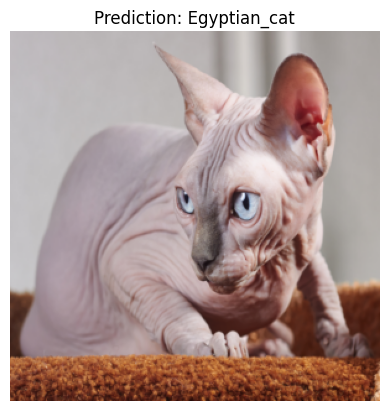

In [288]:
show_image_and_prediction(1)

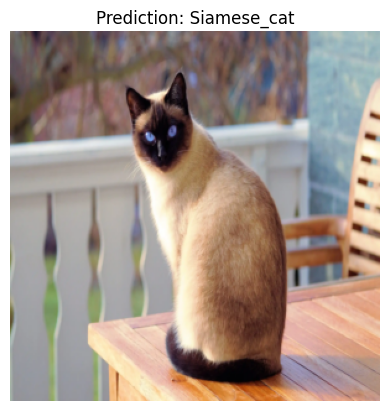

In [289]:
show_image_and_prediction(2)

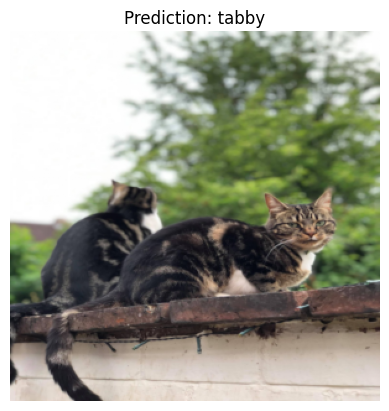

In [290]:
show_image_and_prediction(3)

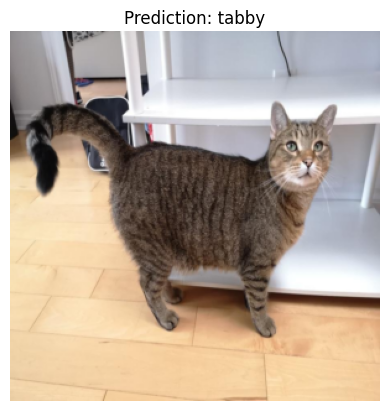

In [291]:
show_image_and_prediction(4)

In [292]:
data_path = "cats" # Path where is images of Cats
all_classes_inception_path = "imagenet_class_index.json" # Path to file of all classes supported by Inception-v3
number_images = 5

epsilon = 0.1
target_class = 924 # Guacamole

adversarial_examples, prediction_names = generate_perturbated_images_with_target(data_path, all_classes_inception_path, number_images, epsilon, target_class)

1 adversarial examples have been found after 24 iterations
2 adversarial examples have been found after 26 iterations
3 adversarial examples have been found after 53 iterations
4 adversarial examples have been found after 70 iterations
5 adversarial examples have been found after 102 iterations


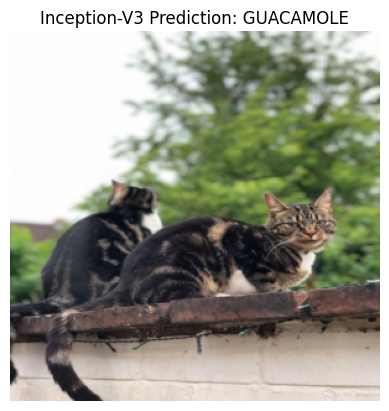

In [293]:
inception_thinks(0)

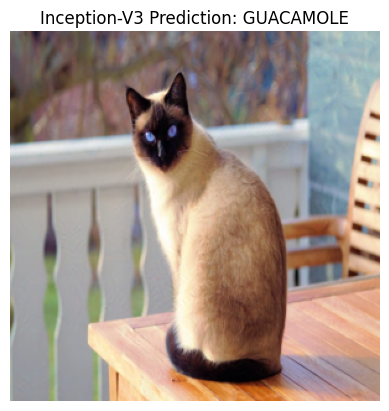

In [294]:
inception_thinks(1)

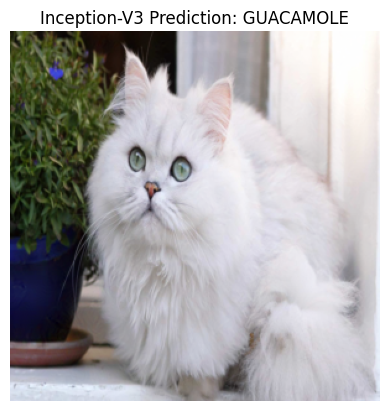

In [295]:
inception_thinks(2)

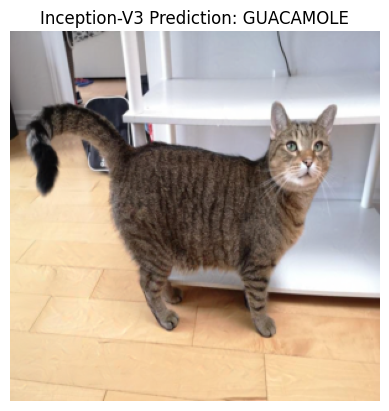

In [296]:
inception_thinks(3)

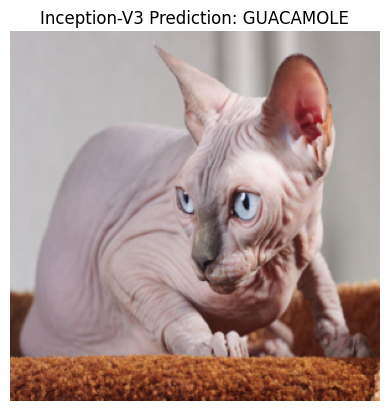

In [297]:
inception_thinks(4)

# 6. Mitigación <a class="anchor" id="mitigation"></a>

Se han realizado grandes investigaciones desde que se descubrió este problema, como en [5] donde los investigadores se dieron cuenta de que añadir ruido al modelo podía aumentar la robustez de un modelo y ayudar a defenderse de los ataques adversarios.

# 7. Conclusión <a class="anchor" id="conclusion"></a>

# Referencias

[1] majestic, “majestic/targeted-adversarial-attack-examples,” GitHub, Jul. 21, 2021. https://github.com/majestic/targeted-adversarial-attack-examples (accessed Nov. 27, 2022).

[2] imsparsh, “Large Categories’ Image Classifier - Inception v3,” Kaggle.com, Jun. 02, 2020. https://www.kaggle.com/code/imsparsh/large-categories-image-classifier-inception-v3/notebook (accessed Nov. 27, 2022).

[3] SZEGEDY, Christian, et al. Rethinking the inception architecture for computer vision. En Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. p. 2818-2826.

[5] YOU, Zhonghui, et al. Adversarial noise layer: Regularize neural network by adding noise. En 2019 IEEE International Conference on Image Processing (ICIP). IEEE, 2019. p. 909-913.